In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
import scipy.stats as stats
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [84]:
# Load the datasets
#train = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
#test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
#submission_sample = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")

In [85]:

# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Here I'm splitting the data before any imputation and feature engineering in order to make sure that the model 
doesn't overfit.

**Overfitting** - A situation where the model perform well on train data but could not perform well on unseen or test data.

If we dont splitting the data before any imputation they may lead to likeage of data which will cause the overfitting

In [86]:
train.shape, test.shape

((1200000, 21), (800000, 20))

In [87]:
train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [88]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(train, train["Premium Amount"], test_size=0.3, random_state=42)
X_train.shape , X_test.shape 

((840000, 21), (360000, 21))

# Dealing with Missing Values
## Categorical Variable
### String type

In [89]:
X_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [90]:
print(X_train.dtypes)

id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date        object
Customer Feedback        object
Smoking Status           object
Exercise Frequency       object
Property Type            object
Premium Amount          float64
dtype: object


In [91]:
# creating a list of all the categorical string type variable having missing values
cat_var_na = []

for label, content in X_train.items():
    if pd.api.types.is_string_dtype(content) and train[label].isnull().sum()*100/ len(X_train)>0:
        cat_var_na.append(label)
        
#checking the missing variable % of missing values
X_train[cat_var_na].isnull().sum()*100/len(X_train)

Series([], dtype: float64)

In [92]:
#divding the list into two sub list

#1st list containing all the variable having  more than 5% of missing values
cat_var_40 = []

#2nd list containing all the variables having missing greater than 0% but less than 5%
cat_var_10 = []


#Running a loop that divide the list into two sub-list
for var in cat_var_na:
    if X_train[var].isnull().sum()*100/len(X_train)>=5:
        cat_var_40.append(var)
    else:
        cat_var_10.append(var)

In [93]:
#filling missing value with "Missing " in those column which has more than 5% of missing values

#filling the missing value with missing label
X_train[cat_var_40] = X_train[cat_var_40].fillna("Missing")

#filling test set
X_test[cat_var_40] = X_test[cat_var_40].fillna("Missing")

#filling na values in given test

test[cat_var_40] = test[cat_var_40].fillna("Missing")

In [94]:
# In case of columns having less than 5%, we are using mode for this

for var in cat_var_10:
    mode_val = X_train[var].mode()[0]
    X_train[var] = X_train[var].fillna(mode_val)
    X_test[var] = X_test[var].fillna(mode_val)
    test[var] = test[var].fillna(mode_val)

In [95]:
# taking all the categorical columns of object type 
cat_var = []

for var in X_train.columns:
    if X_train[var].dtype == "O":
        cat_var.append(var)

In [96]:
#creating function that returns index of frequent values of the column if it exceeds the threshold

def find_frequent(df, var, rare):
    
    """
    this function return the index of all the frequent values that passes the certain threshold
    """
    
    df=df.copy()
    
    temp = df[var].value_counts()/len(df)
    
    return temp[temp>rare].index


In [97]:
#looping through columns and if a column has values less than 3% we tag it as rare

for var in cat_var:
    
    frequent_ls = find_frequent(X_train, var, 0.03)
    
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], "Rare")
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], "Rare")
    test[var] = np.where(test[var].isin(frequent_ls), test[var], "Rare")

In [98]:
#Encoding categorical variable 

def encode(train, test, c_test, target):
    
    ordered_label = train.groupby([var])[target].mean().sort_values().index
    
    ordinal_label = {k: i for i,k in enumerate(ordered_label,0)}
    
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)
    c_test[var] = c_test[var].map(ordinal_label)
    

In [99]:
train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [100]:
#applying the above function
for var in cat_var:
    encode(X_train, X_test, test, "Premium Amount")

# Numerical Variable

In [101]:
#taking numerical variable with missing values

num_var_na = []

for label, content in X_train.items():
    if pd.api.types.is_numeric_dtype(content) and X_train[label].isnull().sum()>0:
            num_var_na.append(label)
        
        
#checking the missing variable % of missing values
X_train[num_var_na].isnull().sum()*100/len(X_train)


Age                      1.559762
Annual Income            3.748810
Number of Dependents     9.150952
Health Score             6.186905
Previous Claims         30.335238
Vehicle Age              0.000476
Credit Score            11.473690
Insurance Duration       0.000119
dtype: float64

In [102]:
#filling the missing values with mode
for var in num_var_na:
    
    #filling missing values with 
    var_mode = X_train[var].mode()[0]
    
    #keeping check on filled missing values
    X_train[var + "_na"] = np.where(X_train[var].isnull(),1,0)
    X_test[var + "_na"] = np.where(X_test[var].isnull(),1,0)
    test[var + "_na"] = np.where(test[var].isnull(),1,0)
    
    X_train[var] = X_train[var].fillna(var_mode)
    X_test[var] = X_test[var].fillna(var_mode)
    test[var] = test[var].fillna(var_mode)
    
#checking agin for missing values    
X_train[num_var_na].isnull().sum()*100/len(X_train)

Age                     0.0
Annual Income           0.0
Number of Dependents    0.0
Health Score            0.0
Previous Claims         0.0
Vehicle Age             0.0
Credit Score            0.0
Insurance Duration      0.0
dtype: float64

# Treating Outlier

In [103]:
cont_var =["Age", "Annual Income", "Health Score", "Credit Score", "Vehicle Age", "Premium Amount"]


In [104]:
#Continious variables
#cont_var = ["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea"]


In [105]:
#this function help to plot the ouliers

def diagnostic(df, var):
    
    """
    This function returns 3 plots
    1) Box Plot
    2) Q-Q Plot
    3) Histogram
    """
    plt.figure(figsize=(20,4))
    
    plt.subplot(1, 3, 1)
    sns.boxplot(df[var])
    plt.title("Box plot-"+ var)
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[var], dist ="norm", plot=plt)
    plt.title("Q-Q-"+ var)
    
    
    plt.subplot(1, 3, 3)
    plt.hist(df[var],bins=30)
    plt.title("Histogram-" + var)

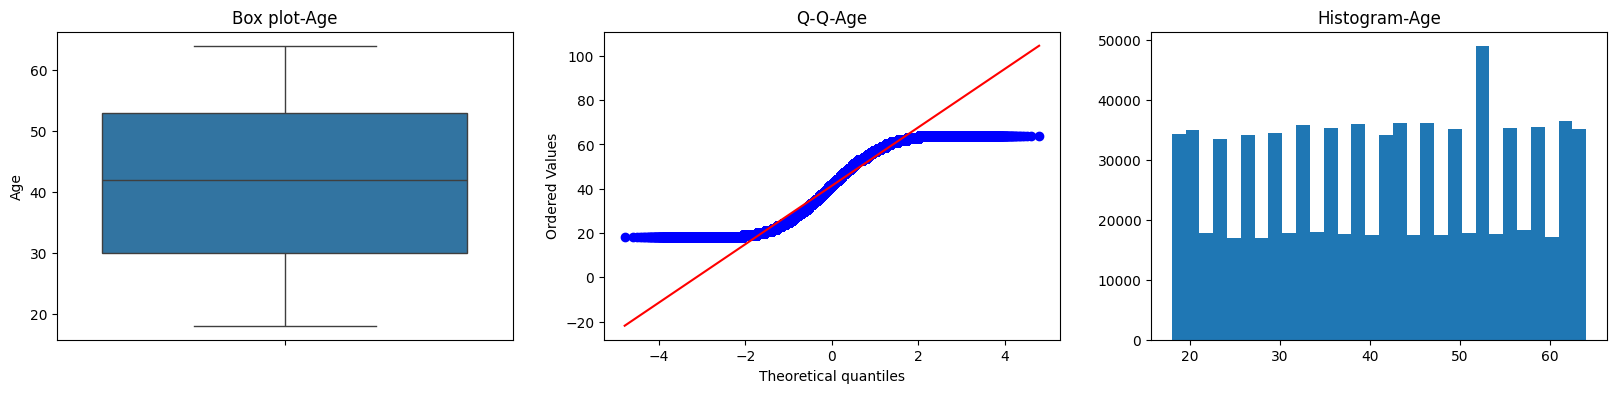

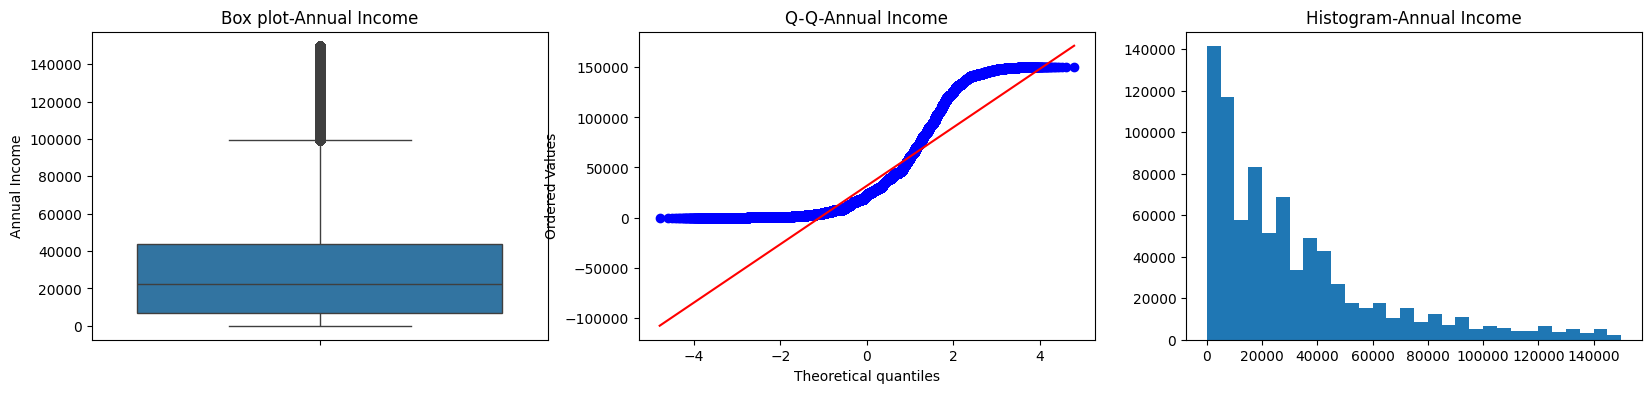

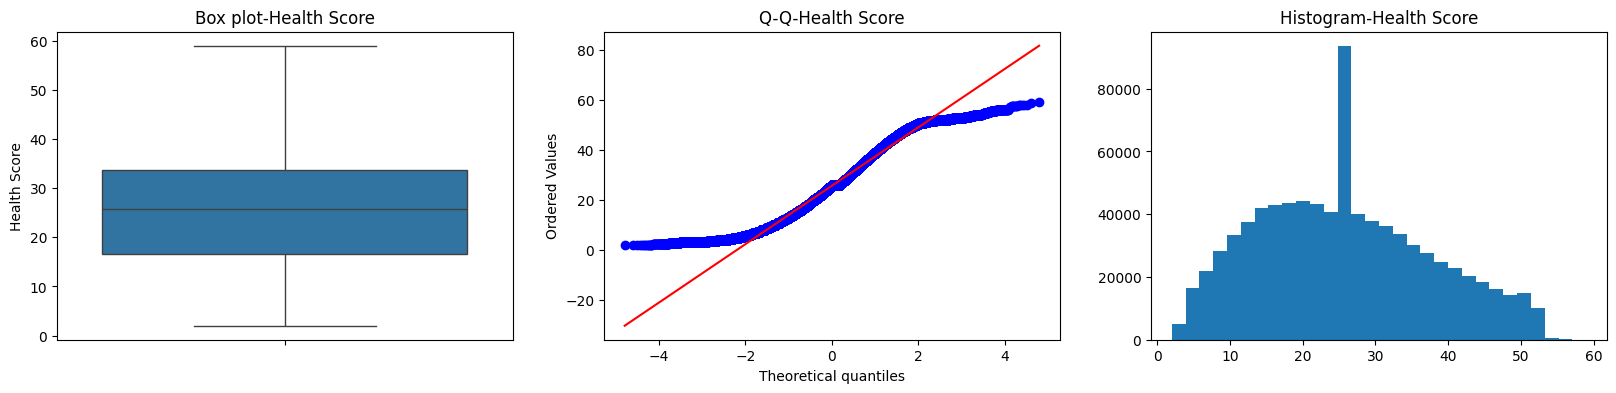

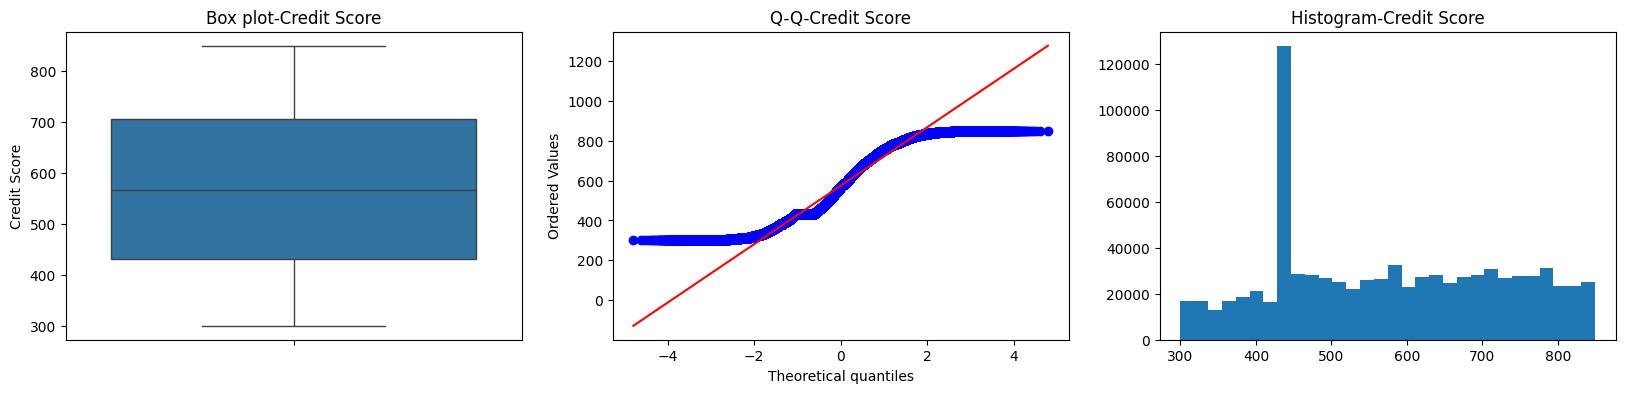

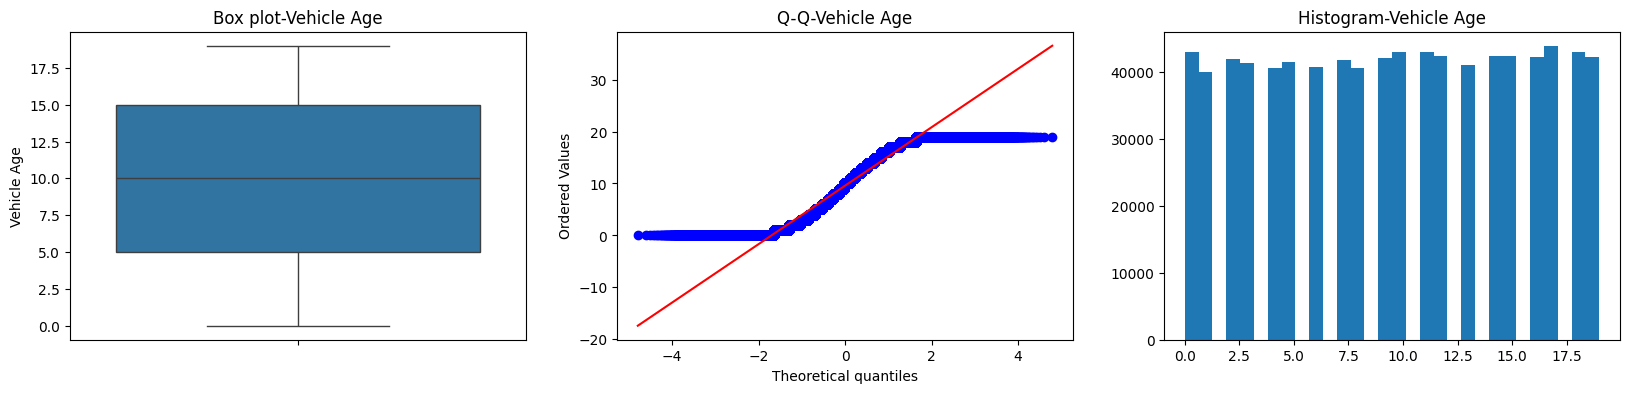

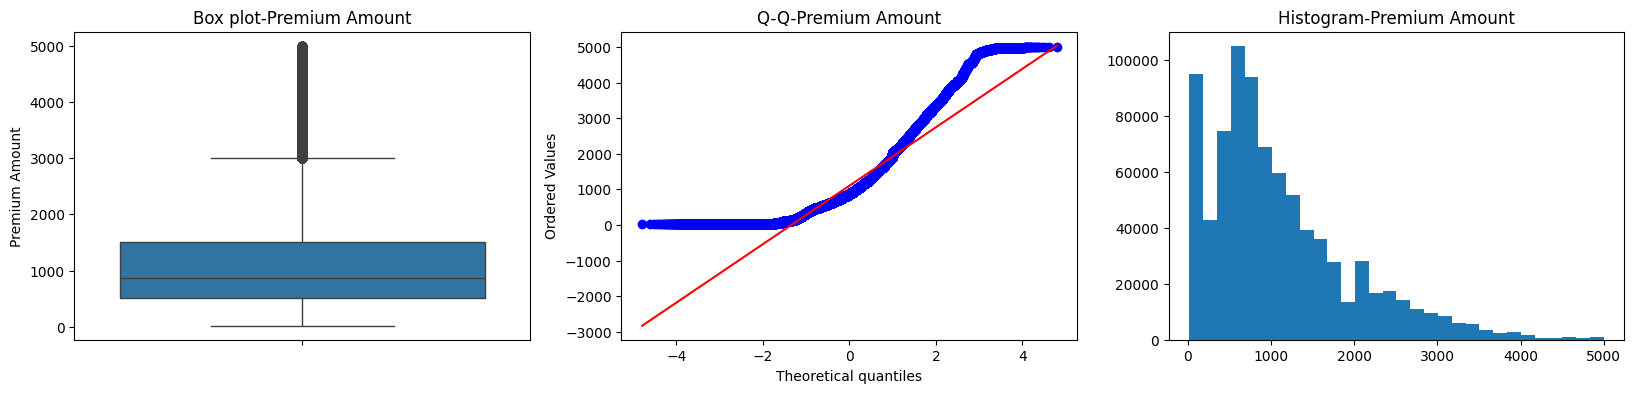

In [106]:
for var in cont_var:
    diagnostic(X_train, var)

In [107]:
#Capping the outliers

def quantile_boundary(df, var, lower_bound, upper_bound):
    
    """
    This function caps the oulier using lower and upper bound 
    decided by use
    """
    
    lower = df[var].quantile(lower_bound)
    upper = df[var].quantile(upper_bound)
    
    return lower, upper

In [108]:
X_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount', 'Age_na', 'Annual Income_na',
       'Number of Dependents_na', 'Health Score_na', 'Previous Claims_na',
       'Vehicle Age_na', 'Credit Score_na', 'Insurance Duration_na'],
      dtype='object')

In [110]:


# Apply capping for each continuous variable
for var in cont_var:
    if var == "Age":
        lower, upper = quantile_boundary(X_train, var, 0.065, 0.95)
    elif var == "Annual Income":
        lower, upper = quantile_boundary(X_train, var, 0.0065, 0.955)
    elif var == "Health Score":
        lower, upper = quantile_boundary(X_train, var, 0.0065, 0.985)
    elif var == "Credit Score":
        lower, upper = quantile_boundary(X_train, var, 0.0065, 0.98)
    elif var == "Vehicle Age":
        lower, upper = quantile_boundary(X_train, var, 0.0065, 0.98)
    elif var == "Premium Amount":
        lower, upper = quantile_boundary(X_train, var, 0.0065, 0.98)

    X_train[var] = np.where(X_train[var] < lower, lower,
                             np.where(X_train[var] > upper, upper, X_train[var]))

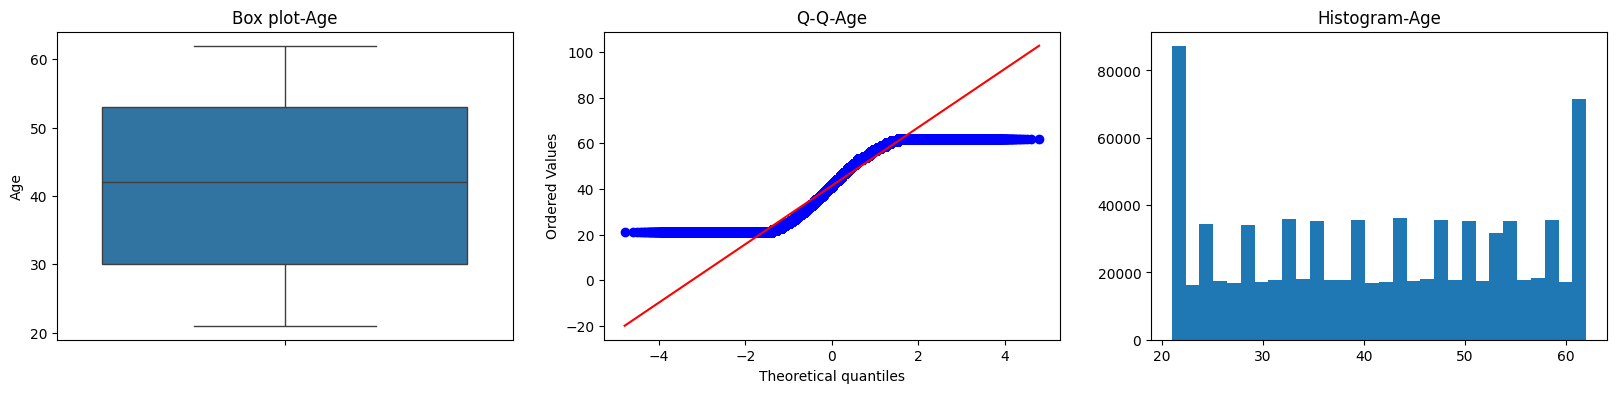

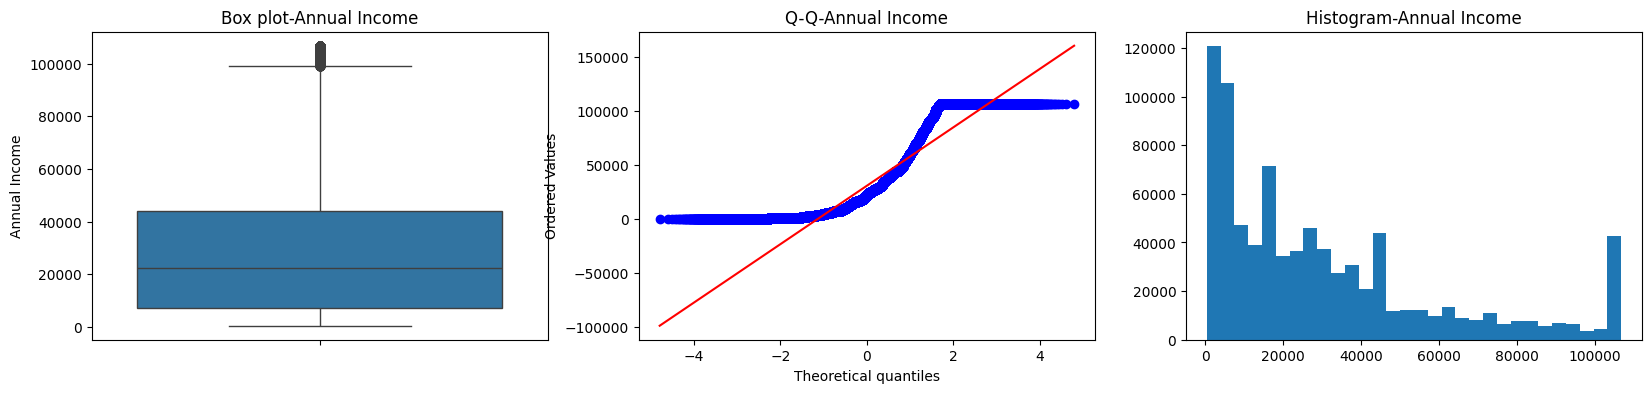

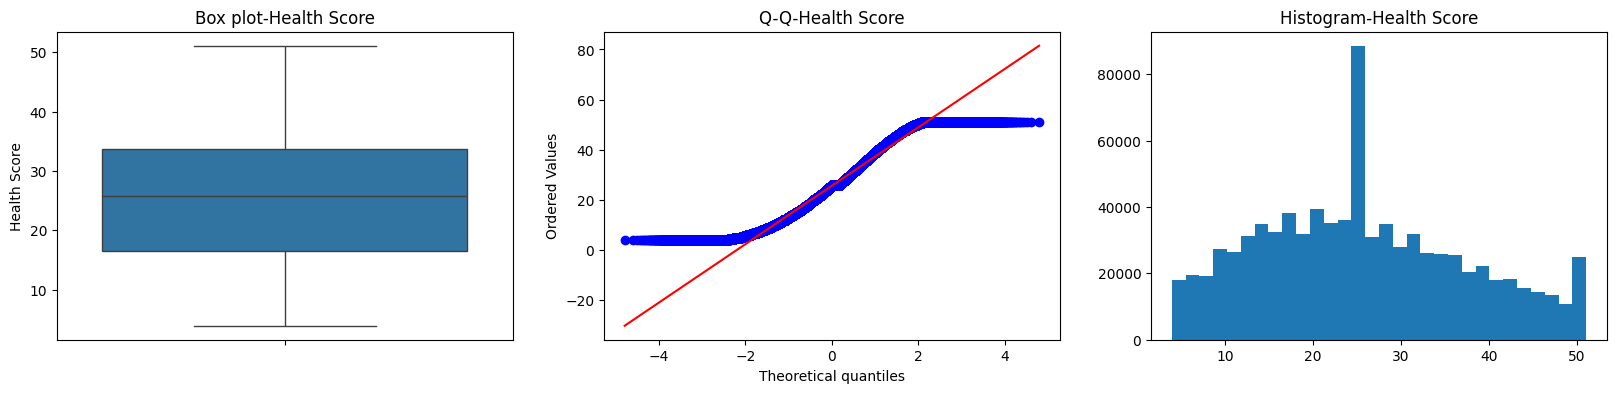

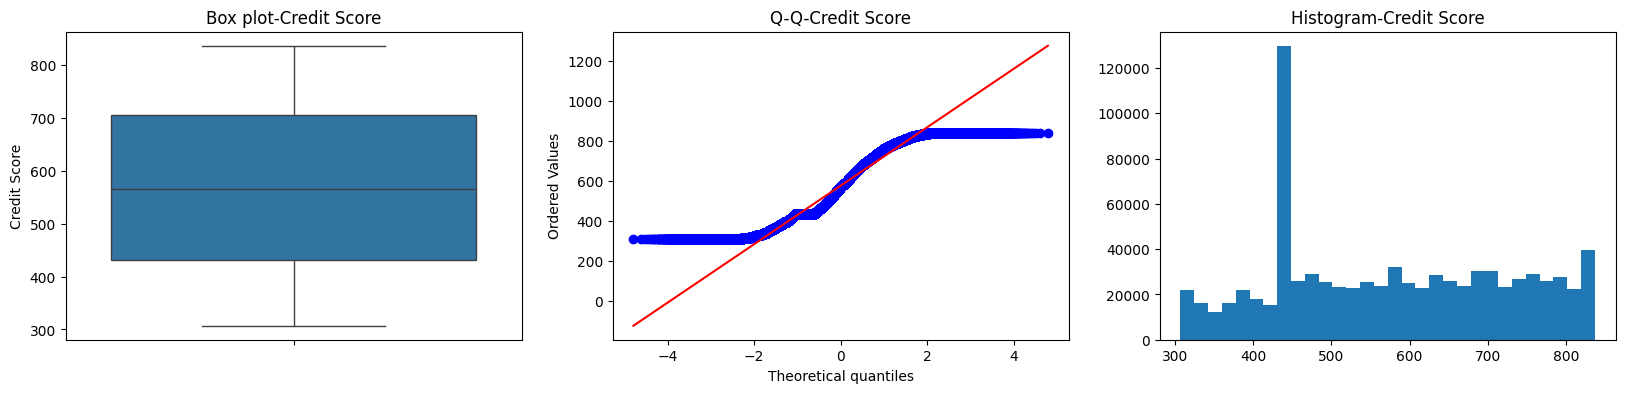

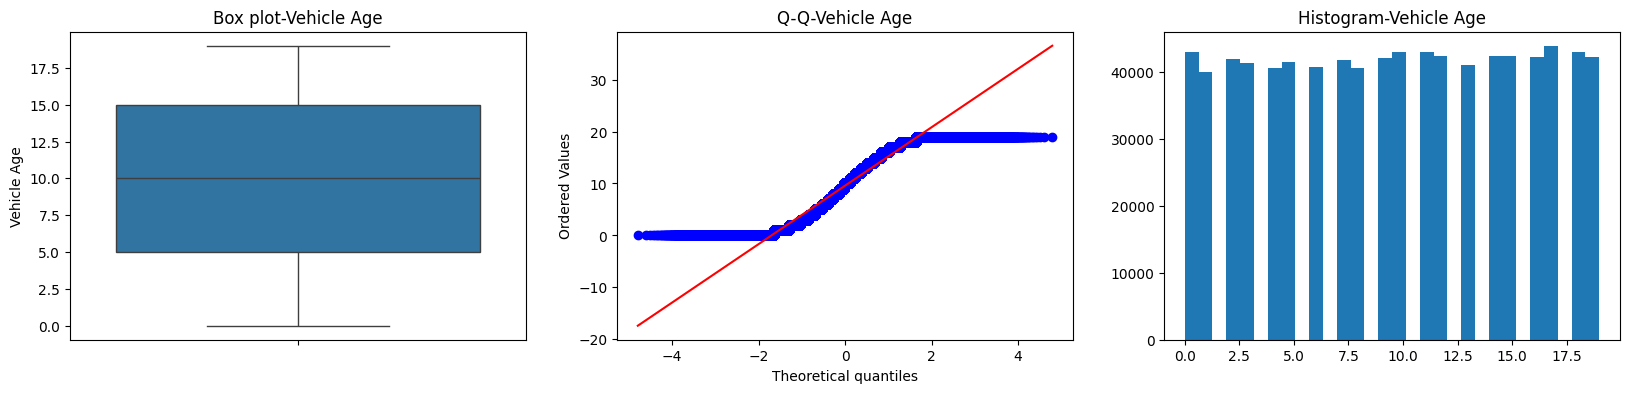

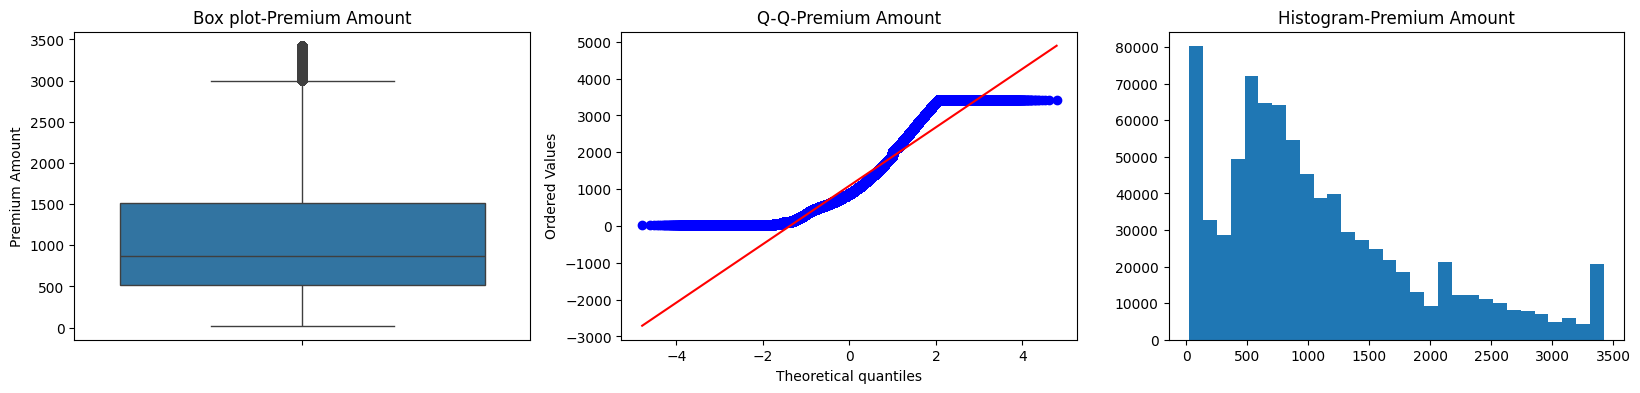

In [111]:
#plotting it again to check whether there are ouliers are not 
for var in cont_var:
    diagnostic(X_train, var)

In [112]:
X_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount', 'Age_na', 'Annual Income_na',
       'Number of Dependents_na', 'Health Score_na', 'Previous Claims_na',
       'Vehicle Age_na', 'Credit Score_na', 'Insurance Duration_na'],
      dtype='object')

In [113]:
#X_train["SalePrice"]=X_train["SalePrice"]**(1/2)
X_train["Premium Amount"]=np.log(X_train["Premium Amount"])

# Time Variable

In [114]:
# writing a function which will convert years into age

def year_to_age(df, var):
    """
    this function takes in year and return the age for that particular varaible
    """
    
    df[var] = df["YrSold"]-df[var]
    
    return df

In [115]:
#applying to all the year column
year_var = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for var in year_var:
    
    X_train = year_to_age(X_train, var)
    X_test = year_to_age(X_test, var)
    test = year_to_age(test, var)


KeyError: 'YrSold'

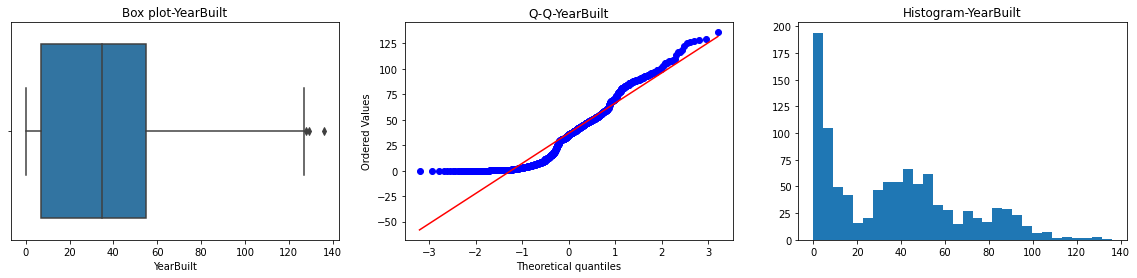

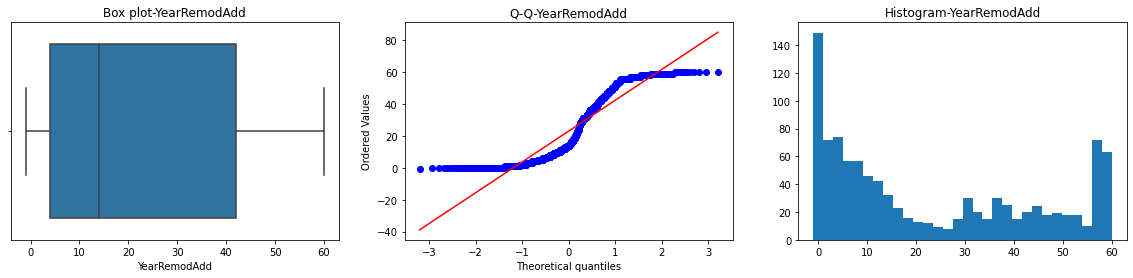

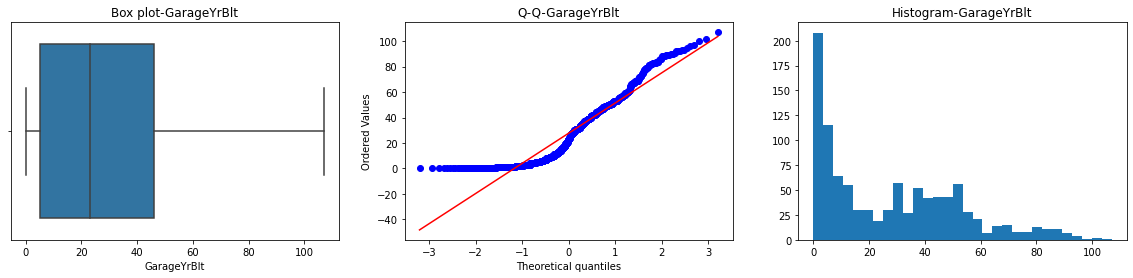

In [26]:
for var in year_var:
    diagnostic(X_train, var)

In [27]:
lower,upper = quantile_boundary(X_train, "YearBuilt",0.065,0.97)
X_train["YearBuilt"] = np.where(X_train["YearBuilt"]<lower,lower,
                           np.where(X_train["YearBuilt"]>upper,upper,X_train["YearBuilt"]))


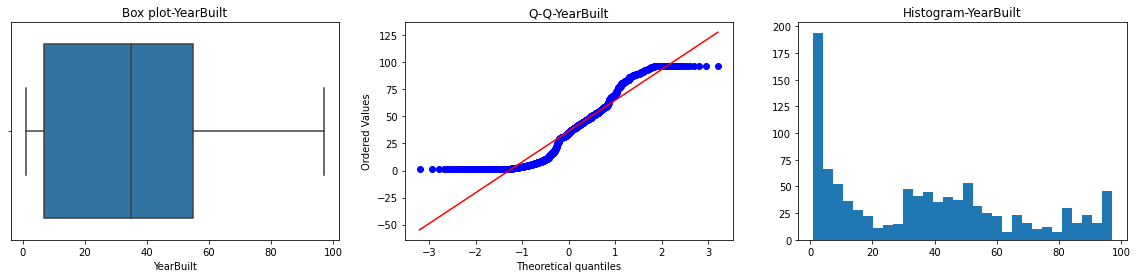

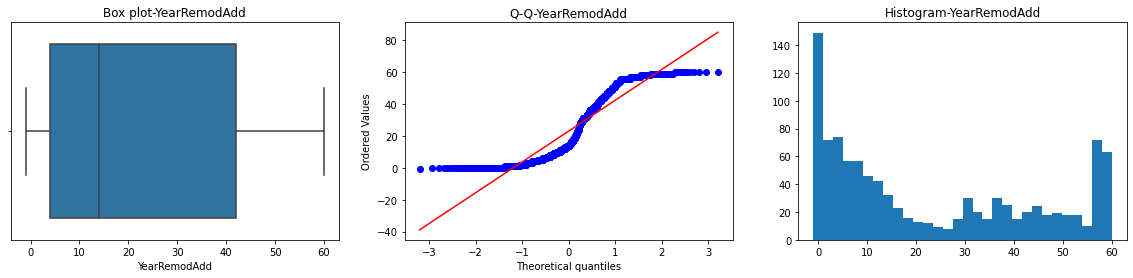

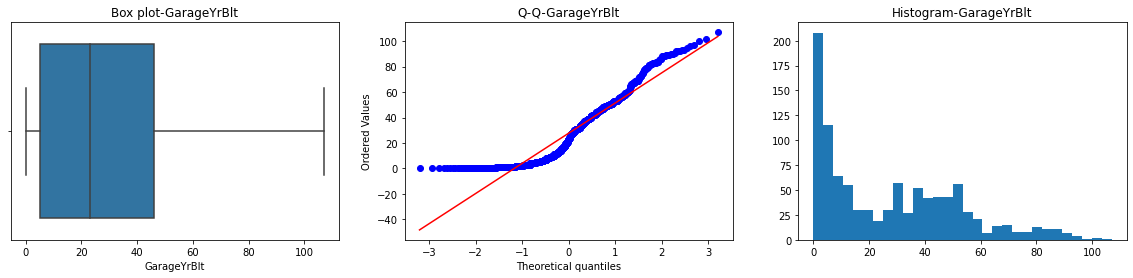

In [28]:
for var in year_var:
    diagnostic(X_train, var)

# Feature Scaling

In [116]:
# capture all variables in a list
# except the target and the ID

feature_scale = [var for var in X_train.columns if var not in ['Id', 'Premium Amount']]

# count number of variables
len(feature_scale)

28

In [117]:
#filling the remaining missing values with mode
for var in feature_scale:
    mode_val = X_train[var].mode()[0]
    test[var] = test[var].fillna(mode_val)

In [118]:
#using min max scaler to scale the features
scaler=MinMaxScaler()

X_train[feature_scale] = scaler.fit_transform(X_train[feature_scale])
X_test[feature_scale] = scaler.transform(X_test[feature_scale])
test[feature_scale] = scaler.transform(test[feature_scale])

# Feature Selection

In [120]:
X_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount', 'Age_na', 'Annual Income_na',
       'Number of Dependents_na', 'Health Score_na', 'Previous Claims_na',
       'Vehicle Age_na', 'Credit Score_na', 'Insurance Duration_na'],
      dtype='object')

In [121]:
# capture the target
y_train = X_train['Premium Amount'].values
y_test = X_test['Premium Amount'].values

# drop unnecessary variables from our training and testing sets
X_train.drop(['id', 'Premium Amount'], axis=1, inplace=True)
X_test.drop(['id', 'Premium Amount'], axis=1, inplace=True)

In [122]:
#using lasso to select the best feature for the data
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel


sfm = SelectFromModel(Lasso(alpha = 0.001, random_state = 0))
sfm.fit(X_train,y_train)
feature_selected = X_train.columns[(sfm.get_support())]
len(feature_selected)

11

In [123]:
#keeping only selected features
X_train=X_train[feature_selected]
X_test = X_test[feature_selected]
test = test[feature_selected]

In [124]:
#creating cross validation rmse
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 14))
    return(rmse)

In [125]:
#fitting Ridge Regression
model_ridge = Ridge()

alphas = [0.08,0.05, 0.1,0.001, 0.3, 1, 3, 5, 10,11, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.min()

1.0825936154455913

In [126]:
#fitting lasso regression
model_lasso = LassoCV(alphas = [0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]).fit(X_train, y_train)
rmse_cv(model_lasso).min()

1.0756411885884392

In [127]:
#fitting Xgboost
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=450, max_depth=3, learning_rate=0.06) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [128]:
rmse_cv(model_xgb).min()

1.0456062533706494

In [129]:
#making predictions on test set

xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

linear_preds = 0.4*xgb_preds+0.6*lasso_preds 

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds,"actual":y_test, 
                            "linear_preds": linear_preds })

predictions["Xgb_error"]=predictions["actual"]-predictions["xgb"]
predictions["Lasso_error"]=predictions["actual"]-predictions["lasso"]
predictions["Linear_error"]=predictions["linear_preds"]-predictions["lasso"]

Text(0.5, 1.0, 'Xg_boost V/s Lasso')

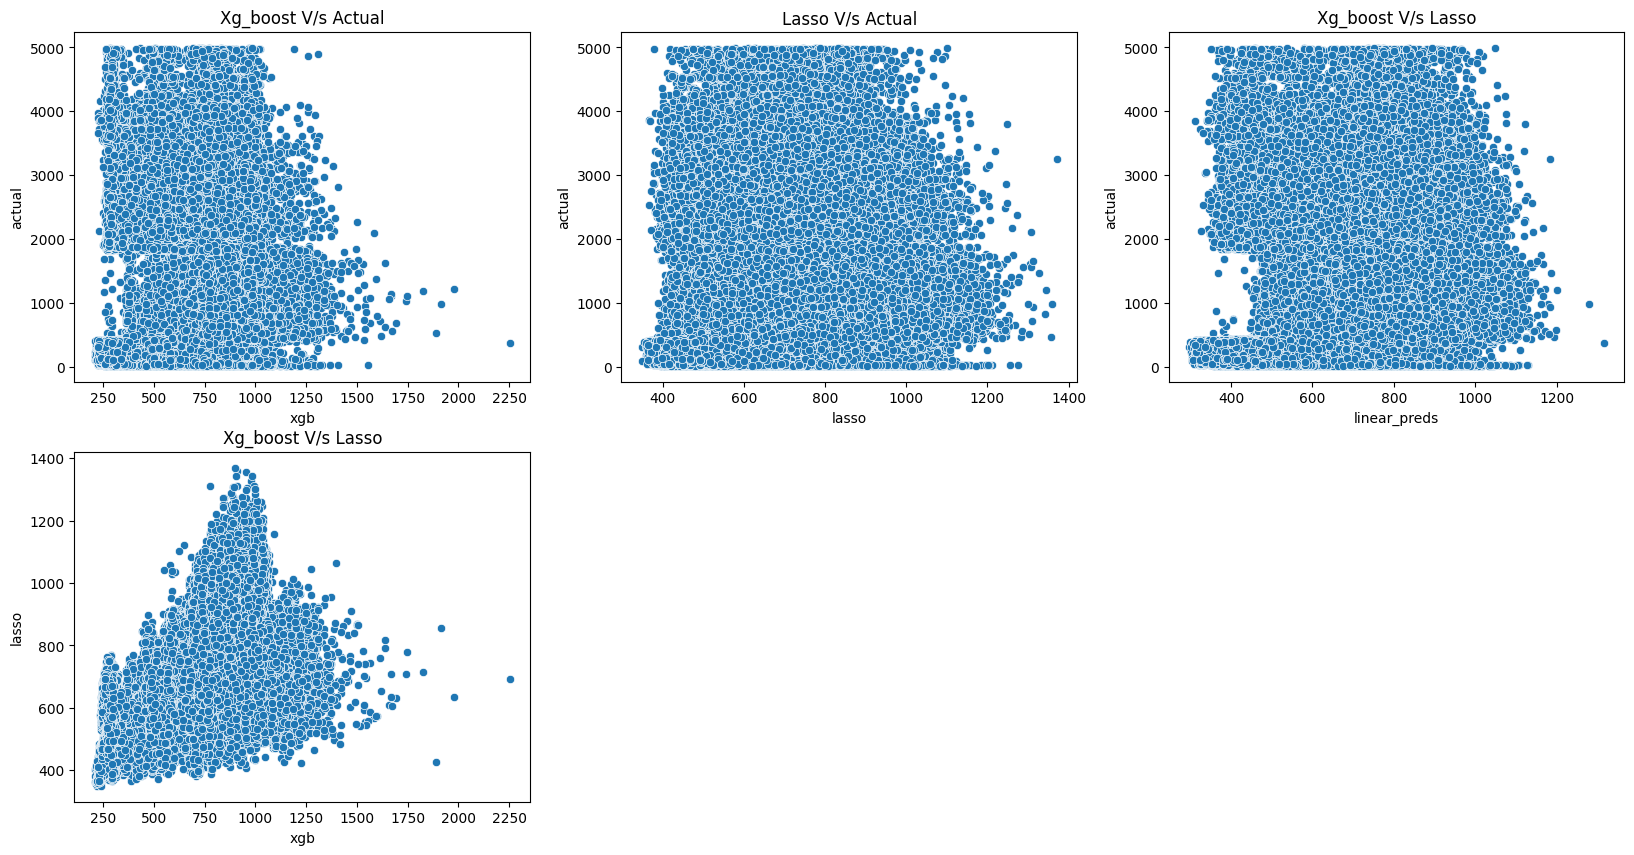

In [130]:
#prediction plots

plt.figure(figsize=(20,10))
    
plt.subplot(2, 3, 1)
sns.scatterplot(x="xgb",y="actual", data=predictions)
plt.title("Xg_boost V/s Actual")
    
plt.subplot(2, 3, 2)
sns.scatterplot(x="lasso",y="actual", data=predictions)
plt.title("Lasso V/s Actual")
       
plt.subplot(2, 3, 3)
sns.scatterplot(x="linear_preds",y="actual", data=predictions)
plt.title("Xg_boost V/s Lasso")




plt.subplot(2, 3, 4)
sns.scatterplot(x="xgb",y="lasso", data=predictions)
plt.title("Xg_boost V/s Lasso")


In [131]:
from sklearn.metrics import r2_score, mean_squared_error
#printing score
print(mean_squared_error(y_test,predictions["linear_preds"])**(1/2))
print(r2_score(y_test,predictions["linear_preds"]))

935.8452195608186
-0.17106158653242654


In [43]:
#test predictions
test_prediction= 0.4*np.expm1(model_xgb.predict(test)) + 0.6*np.expm1(model_lasso.predict(test))

In [44]:
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": test_prediction
    })
submission.to_csv('submission.csv', index=False)